## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

In [6]:
# Check for variables whose values are stored as string. This cannot be analyzed by the regression model
for i in range(len(df.columns)):
    if isinstance(df.iloc[1,i], str):
        print('column ' + df.columns[i])
        print('     ' + df.iloc[1,i])

## Define the analysis to be done

In [7]:
# For Oura and subjective sleep scores
variable_of_interest = 'score'
oura_drop_variables = ['score']
quest_drop_variables = ['subjective_sleep_score']

# # For average HRV
# variable_of_interest = 'average_hrv'
# oura_drop_variables = ['average_hrv']
# quest_drop_variables = []

## Apply Lasso

### Setting the data to be evaluated

In [8]:
# Separate the indenpendent variables from the dependent variables
y = df[variable_of_interest]
X = df.drop(labels=oura_drop_variables+quest_drop_variables, axis=1)
X_oura = df_oura.drop(labels=oura_drop_variables, axis=1)
X_quest = df_quest.drop(labels=quest_drop_variables, axis=1)

In [9]:
def lasso_model(X, y, random_state):
    # Hyperparameter tuning of the alpha value
    scaler = StandardScaler()
    X_scaler = scaler.fit_transform(X)

    # Define model
    model = Lasso(max_iter=10000)

    # Define and execute search
    search = GridSearchCV(model, param_grid = {'alpha':[.00001, 0.0001,0.001, 0.01]}, scoring='neg_mean_squared_error', n_jobs=1, cv=20)
    result = search.fit(X_scaler, y)

    # Print search results
    # print('Grid search results\nBest Score: %s' % result.best_score_)
    print('Grid search results\nBest alpha value: %s\n' % result.best_params_)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    model = Lasso(alpha=result.best_params_['alpha'])
    model.fit(X_train, y_train)

    print("Number of coefficients", len(model.coef_))
    print("Non-zero coeffcients", np.count_nonzero(model.coef_))
    print("Coefficients", model.coef_)
    return model, X_train, X_test, y_train, y_test 

In [10]:
# Compute R squared and mean square error of a given model and training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    print('R squared training set', round(model.score(X_train, y_train), 3))
    print('R squared test set', round(model.score(X_test, y_test), 3))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [11]:
model, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

Grid search results
Best alpha value: {'alpha': 0.001}

Number of coefficients 78
Non-zero coeffcients 44
Coefficients [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -8.35266359e-04
 -2.09366321e-04 -1.18783547e-04  9.43838932e-05  0.00000000e+00
 -1.05672177e-04 -6.83266270e-18  7.03806792e-03  4.24237289e-03
  7.78735384e-03  7.11363781e-03  8.90023880e-03  7.81134691e-03
  3.40345420e-02 -6.37703819e-05 -6.83788230e-03  0.00000000e+00
  1.06211638e-04 -7.44060691e-05 -1.15106462e-03 -3.86263700e-07
  0.00000000e+00  5.24728844e-06  1.16075160e-04  1.16176141e-05
  0.00000000e+00  4.95018496e-03 -3.72866956e-04 -3.96158432e-04
 -6.91916598e-05 -9.82805264e-04  1.85124775e-04 -0.00000000e+00
 -5.36742316e-05 -0.00000000e+00 -1.15083665e-03 -6.68291532e-05
 -1.57427382e-05 -2.19786708e-04  2.14297866e-05 -1.08766196e-02
 -1.74342742e-04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.362e-02, tolerance: 4.697e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [12]:
selected_features = []
for i in range(len(model.coef_)):
    if model.coef_[i] != 0:
        selected_features.append(X_train.columns[i])

print('Number of selected features', len(selected_features))
selected_features

Number of selected features 44


['average_heart_rate',
 'average_hrv',
 'awake_time',
 'bedtime_end_delta',
 'bedtime_start_delta',
 'bedtime_start_seconds',
 'contributors.deep_sleep',
 'contributors.efficiency',
 'contributors.latency',
 'contributors.rem_sleep',
 'contributors.restfulness',
 'contributors.timing',
 'contributors.total_sleep',
 'deep_sleep_duration',
 'efficiency',
 'latency',
 'light_sleep_duration',
 'lowest_heart_rate',
 'lowest_heart_rate_time_offset',
 'readiness.contributors.activity_balance',
 'readiness.contributors.body_temperature',
 'readiness.contributors.hrv_balance',
 'readiness.contributors.previous_night',
 'readiness.contributors.recovery_index',
 'readiness.contributors.resting_heart_rate',
 'readiness.contributors.sleep_balance',
 'readiness.score',
 'readiness.temperature_deviation',
 'rem_sleep_duration',
 'restless_periods',
 'sleep_midpoint',
 'time_in_bed',
 'timezone',
 'total_sleep_duration',
 'wake_ups',
 'prev_oura_score',
 'prev_subjective_score',
 'alcohol_amount',
 'a

In [13]:
pred_train, pred_test = compute_model(model, X_train, y_train, X_test, y_test)

R squared training set 0.999
R squared test set 0.994
MSE training set 0.0
MSE test set 0.002


### Visualizing the results

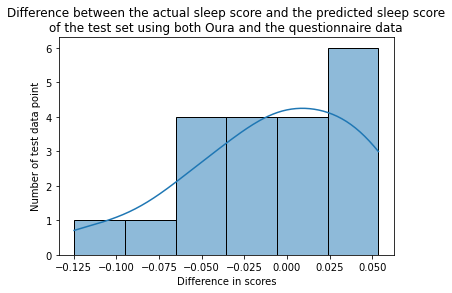

In [14]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

## Apply LassoCV
### Using as independent variables all variables (Oura + questionnaire data)

In [15]:
lasso_cv = LassoCV(alphas=np.arange(0.01, 5, 0.01), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

print('Best alpha:', lasso_cv.alpha_, '\n')
pred_train, pred_test = compute_model(lasso_cv, X_train, y_train, X_test, y_test)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.595e-03, tolerance: 4.294e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.846e-03, tolerance: 4.294e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Best alpha: 0.01 

R squared training set 0.999
R squared test set 0.993
MSE training set 0.001
MSE test set 0.003


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.307e-03, tolerance: 3.790e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### Using as independent variables only the Oura data
#### Lasso

In [16]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=995)

Grid search results
Best alpha value: {'alpha': 0.001}

Number of coefficients 47
Non-zero coeffcients 34
Coefficients [-8.73343972e-05  0.00000000e+00 -1.96907765e-04 -0.00000000e+00
  0.00000000e+00 -1.27444497e-04 -7.16864770e-05  1.00497280e-04
  3.66839800e-18 -1.06069702e-04 -0.00000000e+00  8.24922329e-03
  6.88194644e-03  7.47897212e-03  8.29838102e-03  1.31541153e-02
  8.56716763e-03  3.30670511e-02 -7.41714838e-05 -0.00000000e+00
  0.00000000e+00  7.86282682e-05 -7.81838965e-05 -2.25613333e-03
 -1.80443895e-06 -0.00000000e+00  1.21550153e-04  1.57096394e-05
 -1.11173063e-04  0.00000000e+00  3.80060902e-03 -3.52370248e-04
 -5.64169356e-04  4.82232016e-05  3.99880488e-04 -0.00000000e+00
 -0.00000000e+00 -6.85440694e-05  0.00000000e+00  0.00000000e+00
  3.73415340e-06 -4.60625129e-05  3.45342418e-06  1.78281450e-05
 -1.67701199e-03 -2.52979223e-04  0.00000000e+00]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-02, tolerance: 3.820e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [17]:
pred_train, pred_test = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.999
R squared test set 0.987
MSE training set 0.001
MSE test set 0.011


## Applying the same model on the questionnaire data only

In [18]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=995)

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.907e+00, tolerance: 5.331e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.292e+00, tolerance: 5.271e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might wan

Grid search results
Best alpha value: {'alpha': 0.01}

Number of coefficients 33
Non-zero coeffcients 16
Coefficients [-5.66660837e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.30512889e-03  1.76030574e-02 -0.00000000e+00
  7.43791156e-04  0.00000000e+00 -5.14527500e-01 -1.21479684e-01
 -0.00000000e+00  2.76196416e-04 -4.90802640e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -7.83176533e-01 -4.87422845e-02
 -9.53997786e-05 -0.00000000e+00 -1.19548039e-04  8.29837191e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  4.02327518e-02  0.00000000e+00 -3.40260980e-04
  1.87796726e-04]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.353e+00, tolerance: 3.820e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [19]:
pred_train, pred_test = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.518
R squared test set 0.523
MSE training set 0.239
MSE test set 0.405
